In [1]:
#Import all the necessary files

import datetime
from geneformer import Classifier
import scanpy as sc
import matplotlib.pyplot as plt
import pandas as pd
from geneformer import TranscriptomeTokenizer, DataCollatorForCellClassification 


# Sex Classifier of cell nexus

In [2]:

current_date = datetime.datetime.now()
datestamp = f"{str(current_date.year)[-2:]}{current_date.month:02d}{current_date.day:02d}{current_date.hour:02d}{current_date.minute:02d}{current_date.second:02d}"
datestamp_min = f"{str(current_date.year)[-2:]}{current_date.month:02d}{current_date.day:02d}"

output_prefix = "sex_classifier_cellnexus_v2_blood_cell_type_as_covariate"
output_dir = f"/hpcfs/users/a1841503/trained_classifiers/sex_classifier_v1_cellnexus/{datestamp}"
!mkdir -p $output_dir

In [3]:
#Reading the anndata object
adata=sc.read_h5ad("/hpcfs/users/a1841503/Geneformer/cellnexus/data/combined_anndata.h5ad")
adata.obs.cell_type.describe()
adata.obs.sex.describe()
adata.obs.dataset_id.describe()

count                                   818287
unique                                      36
top       c7775e88-49bf-4ba2-a03b-93f00447c958
freq                                    100000
Name: dataset_id, dtype: object

Sex distribution:
sex
male       391115
female     337567
unknown     89605
Name: count, dtype: int64


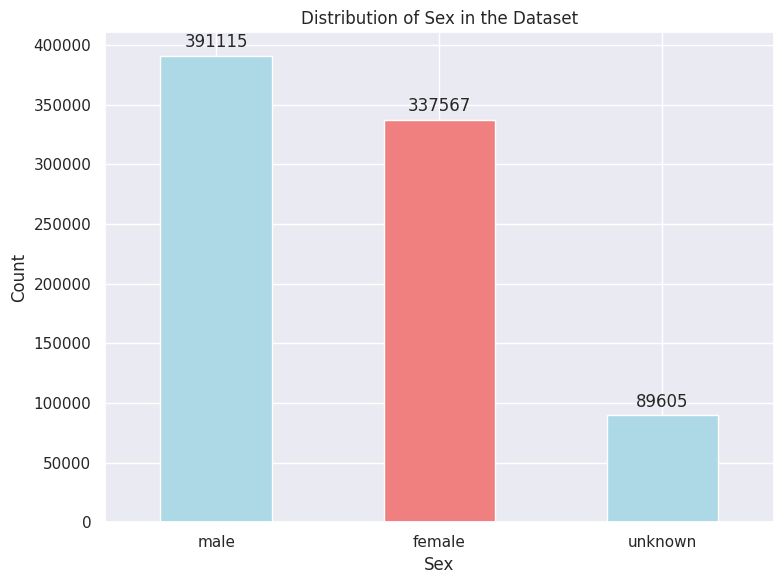

In [4]:
# Get the sex distribution
sex_counts = adata.obs.sex.value_counts()
print("Sex distribution:")
print(sex_counts)

# Create a bar plot
fig, ax = plt.subplots(figsize=(8, 6))
sex_counts.plot(kind='bar', ax=ax, color=['lightblue', 'lightcoral'])
ax.set_title('Distribution of Sex in the Dataset')
ax.set_xlabel('Sex')
ax.set_ylabel('Count')
ax.tick_params(axis='x', rotation=0)

# Add count labels on top of bars
for i, v in enumerate(sex_counts.values):
    ax.text(i, v + max(sex_counts.values) * 0.01, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [5]:
#Removing the unknown from sex column
adata = adata[adata.obs['sex'] != 'unknown']
#adding the ensembl id and count to the anndata object
adata.var["ensembl_id"] = adata.var.index
adata.obs["n_counts"] = adata.X.sum(axis=1)
adata.obs["joinid"] = list(range(adata.n_obs))

#Saving the anndata object
adata.write_h5ad("/hpcfs/users/a1841503/Geneformer/cellnexus/data/sex/cell_type/anndata/combined_anndata_no_unknown.h5ad")

/mnt/tmp_local/lls_5541094/ipykernel_122949/133117011.py:4: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["ensembl_id"] = adata.var.index


Sex distribution:
sex
male      391115
female    337567
Name: count, dtype: int64


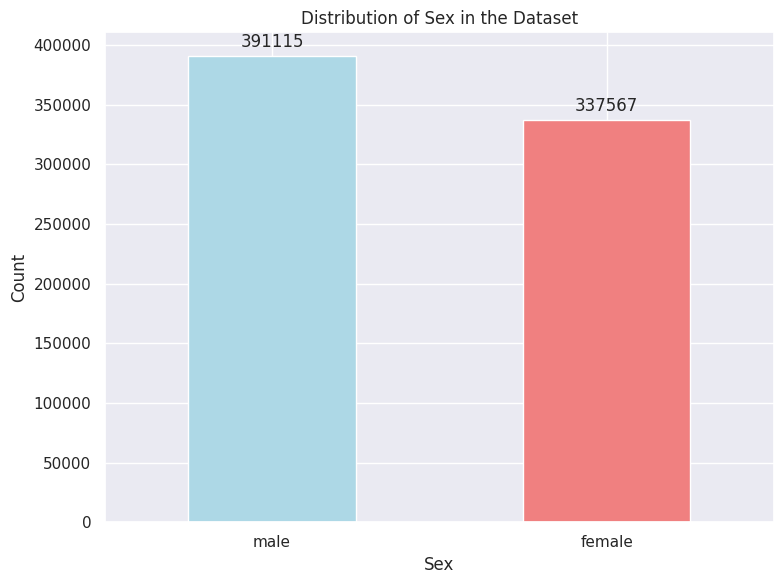

In [6]:
# Get the sex distribution
sex_counts = adata.obs.sex.value_counts()
print("Sex distribution:")
print(sex_counts)

# Bar plot
fig, ax = plt.subplots(figsize=(8, 6))
sex_counts.plot(kind='bar', ax=ax, color=['lightblue', 'lightcoral'])
ax.set_title('Distribution of Sex in the Dataset')
ax.set_xlabel('Sex')
ax.set_ylabel('Count')
ax.tick_params(axis='x', rotation=0)

# Add count labels on top of bars
for i, v in enumerate(sex_counts.values):
    ax.text(i, v + max(sex_counts.values) * 0.01, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [7]:

# Geneformer directories for the 2048 model
gene_median_file_2048="/hpcfs/users/a1841503/Geneformer/geneformer/gene_dictionaries_30m/gene_median_dictionary_gc30M.pkl" 
token_dictionary_file_2048= "/hpcfs/users/a1841503/Geneformer/geneformer/gene_dictionaries_30m/token_dictionary_gc30M.pkl"
gene_mapping_file_2048= "/hpcfs/users/a1841503/Geneformer/geneformer/gene_dictionaries_30m/ensembl_mapping_dict_gc30M.pkl"

tk = TranscriptomeTokenizer(custom_attr_name_dict={"joinid": "joinid","sex": "sex","cell_type": "cell_type","dataset_id": "dataset_id"},
                            model_input_size = 2048,
                            special_token = False,
                            gene_median_file=gene_median_file_2048 ,
                            token_dictionary_file= token_dictionary_file_2048,
                            gene_mapping_file= gene_mapping_file_2048)

In [8]:
data_directory="/hpcfs/users/a1841503/Geneformer/cellnexus/data/sex/cell_type/anndata/"
token_dir="/hpcfs/users/a1841503/Geneformer/cellnexus/data/sex/cell_type/tokenized_combined_data/"
tk.tokenize_data(data_directory=data_directory,
                 output_directory=token_dir, 
                 output_prefix="sex_cell_type", 
                 file_format="h5ad")

Tokenizing /hpcfs/users/a1841503/Geneformer/cellnexus/data/sex/cell_type/anndata/combined_anndata_no_unknown.h5ad


/hpcfs/users/a1841503/myconda/envs/jupyter_geneformer/lib/python3.12/site-packages/geneformer/tokenizer.py:495: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for i in adata.var["ensembl_id_collapsed"][coding_miRNA_loc]
/hpcfs/users/a1841503/myconda/envs/jupyter_geneformer/lib/python3.12/site-packages/geneformer/tokenizer.py:498: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coding_miRNA_ids = adata.var["ensembl_id_collapsed"][coding_miRNA_loc]


/hpcfs/users/a1841503/Geneformer/cellnexus/data/sex/cell_type/anndata/combined_anndata_no_unknown.h5ad has no column attribute 'filter_pass'; tokenizing all cells.
Creating dataset.


In [9]:
filter_data_dict={"sex":["male","female"]}
training_args = {
    "num_train_epochs": 0.9,
    "learning_rate": 0.000804,
    "lr_scheduler_type": "polynomial",
    "warmup_steps": 1812,
    "weight_decay":0.258828,
    "per_device_train_batch_size": 12,
    "seed": 73,
}

# OF NOTE: model_version should match version of model to be used (V1 or V2) to use the correct token dictionary
cc = Classifier(classifier="cell",
                cell_state_dict = {"state_key": "sex", "states": "all"},
                filter_data=filter_data_dict,
                training_args=training_args,
                max_ncells=None,
                freeze_layers = 2,
                num_crossval_splits = 1,
                forward_batch_size=100,
                nproc=16)

In [10]:
datset_id_list=[
 '9dbab10c-118d-496b-966a-67f1763a6b7d',
 'bd65a70f-b274-4133-b9dd-0d1431b6af34',
 'cf83c98a-3791-4537-bbde-a719f6d73c13',
 '19e46756-9100-4e01-8b0e-23b557558a4c',
 'd7d7e89c-c93a-422d-8958-9b4a90b69558',
 'de2c780c-1747-40bd-9ccf-9588ec186cee',
 'ebc2e1ff-c8f9-466a-acf4-9d291afaf8b3',
 '01ad3cd7-3929-4654-84c0-6db05bd5fd59',
 '218acb0f-9f2f-4f76-b90b-15a4b7c7f629',
 '242c6e7f-9016-4048-af70-d631f5eea188',
 '2a498ace-872a-4935-984b-1afa70fd9886',
 '3c75a463-6a87-4132-83a8-c3002624394d',
 '1b9d8702-5af8-4142-85ed-020eb06ec4f6',
 '21d3e683-80a4-4d9b-bc89-ebb2df513dde',
 '30cd5311-6c09-46c9-94f1-71fe4b91813c',
 '3faad104-2ab8-4434-816d-474d8d2641db',
 '50eb1e23-b8d4-4f76-a184-44e5541fa05a',
 '53d208b0-2cfd-4366-9866-c3c6114081bc',
 '59b69042-47c2-47fd-ad03-d21beb99818f',
 '5af90777-6760-4003-9dba-8f945fec6fdf',
 '5bc42b88-bb76-4954-927b-8bb7369adc64',
 '5e717147-0f75-4de1-8bd2-6fda01b8d75f',
 '74cff64f-9da9-4b2a-9b3b-8a04a1598040',
 '79ef1959-a6b4-4cac-82ca-30feaec48df1',
 '84230ea4-998d-4aa8-8456-81dd54ce23af',
 '881fe679-c6e0-45a3-9427-c4e81be6921f',
 '8c42cfd0-0b0a-46d5-910c-fc833d83c45e',
 '8a554710-08bc-4005-87cd-da9675bdc2e7',
 'b0e547f0-462b-4f81-b31b-5b0a5d96f537',
 'c2a461b1-0c15-4047-9fcb-1f966fe55100',
 'c7775e88-49bf-4ba2-a03b-93f00447c958',
 'cab0bc48-744c-461b-aaf4-7bf2cb7af00d',
 'db59611b-42de-4035-93aa-1ed39f38b467',
 'ed5d841d-6346-47d4-ab2f-7119ad7e3a35',
 'eeacb0c1-2217-4cf6-b8ce-1f0fedf1b569',
 'fa8605cf-f27e-44af-ac2a-476bee4410d3']

In [11]:
# Manually balanced splits
# argument attr_to_split set to "dataset_id" and attr_to_balance set to ["sex"]
#Categories (11, object): ['01ad3cd7-3929-4654-84c0-6db05bd5fd59', '2a498ace-872a-4935-984b-1afa70fd9886', '3faad104-2ab8-4434-816d-474d8d2641db', '19e46756-9100-4e01-8b0e-23b557558a4c', ..., '59b69042-47c2-47fd-ad03-d21beb99818f', '218acb0f-9f2f-4f76-b90b-15a4b7c7f629', '242c6e7f-9016-4048-af70-d631f5eea188', 'b0e547f0-462b-4f81-b31b-5b0a5d96f537']
test_ids= ['21d3e683-80a4-4d9b-bc89-ebb2df513dde', '19e46756-9100-4e01-8b0e-23b557558a4c']
eval_ids= ['59b69042-47c2-47fd-ad03-d21beb99818f', 'b0e547f0-462b-4f81-b31b-5b0a5d96f537']
train_ids= ['242c6e7f-9016-4048-af70-d631f5eea188', '218acb0f-9f2f-4f76-b90b-15a4b7c7f629', '53d208b0-2cfd-4366-9866-c3c6114081bc','01ad3cd7-3929-4654-84c0-6db05bd5fd59','3faad104-2ab8-4434-816d-474d8d2641db','2a498ace-872a-4935-984b-1afa70fd9886','30cd5311-6c09-46c9-94f1-71fe4b91813c']
train_test_id_split_dict = {"attr_key": "dataset_id",
                            "train": train_ids+eval_ids,
                            "test": test_ids}
attr_to_balance =["sex"] 
input_data_file="/hpcfs/users/a1841503/Geneformer/cellnexus/data/sex/cell_type/tokenized_combined_data/sex_cell_type.dataset"
output_directory="/hpcfs/users/a1841503/Geneformer/cellnexus/data/sex/cell_type/prepared_tokenized_combined_data/"
split_id_dict={"attr_key": "dataset_id",
 "train":  ['242c6e7f-9016-4048-af70-d631f5eea188', '218acb0f-9f2f-4f76-b90b-15a4b7c7f629', '53d208b0-2cfd-4366-9866-c3c6114081bc','01ad3cd7-3929-4654-84c0-6db05bd5fd59','3faad104-2ab8-4434-816d-474d8d2641db','2a498ace-872a-4935-984b-1afa70fd9886','30cd5311-6c09-46c9-94f1-71fe4b91813c'],
 "test": ['21d3e683-80a4-4d9b-bc89-ebb2df513dde', '19e46756-9100-4e01-8b0e-23b557558a4c','59b69042-47c2-47fd-ad03-d21beb99818f', 'b0e547f0-462b-4f81-b31b-5b0a5d96f537']}
# Example input_data_file for 30M model: https://huggingface.co/datasets/ctheodoris/Genecorpus-30M/tree/main/example_input_files/cell_classification/disease_classification/human_dcm_hcm_nf.dataset
cc.prepare_data(input_data_file=input_data_file,
                output_directory=output_directory,
                output_prefix=output_prefix,
                split_id_dict=split_id_dict,
                attr_to_balance=attr_to_balance,)

In [ ]:
model_directory="/hpcfs/groups/phoenix-hpc-mangiola_laboratory/haroon/geneformer/trained_foundation_models/models/30M_AGGsinglecell_6_emb256_SL2048_E2_B12_LR0.001_LSlinear_WU10000_Oadamw/checkpoint-75000"

train_valid_id_split_dict = {"attr_key": "dataset_id",
                            "train": train_ids,
                            "eval": eval_ids}
attr_to_balance=["cell_type","sex"]





# V1 model: https://huggingface.co/ctheodoris/Geneformer/blob/main/Geneformer-V1-10M/model.safetensors
all_metrics = cc.validate(model_directory=model_directory,  # OF NOTE: SET TO V1 MODEL ABOVE, PROVIDE V1 MODEL PATH HERE
                          prepared_input_data_file="/hpcfs/users/a1841503/Geneformer/cellnexus/trained_classifiers/sex_classifier_v1_cellnexus/250820181105/sex_classifier_cellnexus_v2_celltype_as_covariate_labeled_train.dataset",
                          id_class_dict_file="/hpcfs/users/a1841503/Geneformer/cellnexus/data/sex/cell_type/prepared_tokenized_combined_data/sex_classifier_cellnexus_v2_blood_cell_type_as_covariate_id_class_dict.pkl",
                          output_directory=output_dir,
                          output_prefix=output_prefix,
                          n_hyperopt_trials=10,
                          attr_to_balance=attr_to_balance,
                          predict_eval=True,
                          predict_trainer=False,
                          save_eval_output=True,
                          )
                          # to optimize hyperparameters, set n_hyperopt_trials=100 (or alternative desired # of trials)

  0%|          | 0/1 [00:00<?, ?it/s]

****** Validation split: 1/1 ******



2025-09-09 11:46:04,491	INFO worker.py:1841 -- Started a local Ray instance.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /hpcfs/groups/phoenix-hpc-mangiola_laboratory/haroon/geneformer/trained_foundation_models/models/30M_AGGsinglecell_6_emb256_SL2048_E2_B12_LR0.001_LSlinear_WU10000_Oadamw/checkpoint-75000 and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/hpcfs/users/a1841503/myconda/envs/jupyter_geneformer/lib/python3.12/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to

== Status ==
Current time: 2025-09-09 11:46:07 (running for 00:00:00.13)
Using FIFO scheduling algorithm.
Logical resource usage: 0/72 CPUs, 0/4 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /mnt/tmp_local/lls_5541094/ray/session_2025-09-09_11-46-02_362098_122949/artifacts/2025-09-09_11-46-07/_objective_2025-09-09_11-46-07/driver_artifacts
Number of trials: 1/10 (1 PENDING)
+---------------------+----------+-------+-----------------+---------------------+--------------------+------------------------+---------+----------------+----------------+
| Trial name          | status   | loc   |   learning_rate | lr_scheduler_type   |   num_train_epochs |   per_device_train_bat |    seed |   warmup_steps |   weight_decay |
|                     |          |       |                 |                     |                    |                ch_size |         |                |                |
|---------------------+----------+-------+-----------------+---------------------+----------------

(_objective pid=129103) Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
(_objective pid=129103) Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /hpcfs/groups/phoenix-hpc-mangiola_laboratory/haroon/geneformer/trained_foundation_models/models/30M_AGGsinglecell_6_emb256_SL2048_E2_B12_LR0.001_LSlinear_WU10000_Oadamw/checkpoint-75000 and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
(_objective pid=129103) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|          | 0/85166 [00:00<?, ?it/s]/hpcfs/users/a1841503/myconda/envs/jupyter_geneformer/lib/python3.12/site-packages/geneformer/collator_for_classification.py:644: UserWarning: To copy construct from a tensor, it i

== Status ==
Current time: 2025-09-09 11:56:07 (running for 00:10:00.23)
Using FIFO scheduling algorithm.
Logical resource usage: 64.0/72 CPUs, 4.0/4 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /mnt/tmp_local/lls_5541094/ray/session_2025-09-09_11-46-02_362098_122949/artifacts/2025-09-09_11-46-07/_objective_2025-09-09_11-46-07/driver_artifacts
Number of trials: 5/10 (1 PENDING, 4 RUNNING)
+---------------------+----------+---------------------+-----------------+---------------------+--------------------+------------------------+---------+----------------+----------------+
| Trial name          | status   | loc                 |   learning_rate | lr_scheduler_type   |   num_train_epochs |   per_device_train_bat |    seed |   warmup_steps |   weight_decay |
|                     |          |                     |                 |                     |                    |                ch_size |         |                |                |
|---------------------+----------+------

 10%|▉         | 8487/85166 [16:50<2:31:34,  8.43it/s] [repeated 164x across cluster]


(_objective pid=129103) {'loss': 0.2585, 'grad_norm': 4.8505024909973145, 'learning_rate': 0.0002915399499993264, 'epoch': 0.1}


 10%|█         | 8616/85166 [17:05<2:34:34,  8.25it/s] [repeated 165x across cluster]


(_objective pid=129276) {'loss': 0.5651, 'grad_norm': 0.9775413870811462, 'learning_rate': 0.0007300307639165742, 'epoch': 0.1} [repeated 2x across cluster]


 12%|█▏        | 9799/85166 [19:42<2:34:47,  8.11it/s] [repeated 155x across cluster]


== Status ==
Current time: 2025-09-09 12:06:07 (running for 00:20:00.23)
Using FIFO scheduling algorithm.
Logical resource usage: 64.0/72 CPUs, 4.0/4 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /mnt/tmp_local/lls_5541094/ray/session_2025-09-09_11-46-02_362098_122949/artifacts/2025-09-09_11-46-07/_objective_2025-09-09_11-46-07/driver_artifacts
Number of trials: 5/10 (1 PENDING, 4 RUNNING)
+---------------------+----------+---------------------+-----------------+---------------------+--------------------+------------------------+---------+----------------+----------------+
| Trial name          | status   | loc                 |   learning_rate | lr_scheduler_type   |   num_train_epochs |   per_device_train_bat |    seed |   warmup_steps |   weight_decay |
|                     |          |                     |                 |                     |                    |                ch_size |         |                |                |
|---------------------+----------+------

 17%|█▋        | 14722/85166 [29:41<2:25:04,  8.09it/s] [repeated 157x across cluster]


== Status ==
Current time: 2025-09-09 12:16:07 (running for 00:30:00.24)
Using FIFO scheduling algorithm.
Logical resource usage: 64.0/72 CPUs, 4.0/4 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /mnt/tmp_local/lls_5541094/ray/session_2025-09-09_11-46-02_362098_122949/artifacts/2025-09-09_11-46-07/_objective_2025-09-09_11-46-07/driver_artifacts
Number of trials: 5/10 (1 PENDING, 4 RUNNING)
+---------------------+----------+---------------------+-----------------+---------------------+--------------------+------------------------+---------+----------------+----------------+
| Trial name          | status   | loc                 |   learning_rate | lr_scheduler_type   |   num_train_epochs |   per_device_train_bat |    seed |   warmup_steps |   weight_decay |
|                     |          |                     |                 |                     |                    |                ch_size |         |                |                |
|---------------------+----------+------

 20%|█▉        | 16995/85166 [33:54<2:18:24,  8.21it/s] [repeated 158x across cluster]


(_objective pid=129103) {'loss': 0.2089, 'grad_norm': 0.5996057987213135, 'learning_rate': 0.0002708829811427088, 'epoch': 0.2} [repeated 2x across cluster]


 20%|██        | 17076/85166 [34:04<2:17:51,  8.23it/s] [repeated 160x across cluster]


(_objective pid=129674) {'loss': 0.2513, 'grad_norm': 10.73942756652832, 'learning_rate': 1.5231383364339628e-05, 'epoch': 0.2}


 20%|██        | 17245/85166 [34:25<2:12:53,  8.52it/s] [repeated 156x across cluster]


(_objective pid=129276) {'loss': 0.6932, 'grad_norm': 0.22170045971870422, 'learning_rate': 0.0006817548838283431, 'epoch': 0.2}


 23%|██▎       | 19896/85166 [39:44<1:55:48,  9.39it/s] [repeated 158x across cluster]


== Status ==
Current time: 2025-09-09 12:26:07 (running for 00:40:00.33)
Using FIFO scheduling algorithm.
Logical resource usage: 64.0/72 CPUs, 4.0/4 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /mnt/tmp_local/lls_5541094/ray/session_2025-09-09_11-46-02_362098_122949/artifacts/2025-09-09_11-46-07/_objective_2025-09-09_11-46-07/driver_artifacts
Number of trials: 5/10 (1 PENDING, 4 RUNNING)
+---------------------+----------+---------------------+-----------------+---------------------+--------------------+------------------------+---------+----------------+----------------+
| Trial name          | status   | loc                 |   learning_rate | lr_scheduler_type   |   num_train_epochs |   per_device_train_bat |    seed |   warmup_steps |   weight_decay |
|                     |          |                     |                 |                     |                    |                ch_size |         |                |                |
|---------------------+----------+------

 29%|██▉       | 24562/85166 [49:43<2:02:47,  8.23it/s] [repeated 158x across cluster]


== Status ==
Current time: 2025-09-09 12:36:08 (running for 00:50:00.42)
Using FIFO scheduling algorithm.
Logical resource usage: 64.0/72 CPUs, 4.0/4 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /mnt/tmp_local/lls_5541094/ray/session_2025-09-09_11-46-02_362098_122949/artifacts/2025-09-09_11-46-07/_objective_2025-09-09_11-46-07/driver_artifacts
Number of trials: 5/10 (1 PENDING, 4 RUNNING)
+---------------------+----------+---------------------+-----------------+---------------------+--------------------+------------------------+---------+----------------+----------------+
| Trial name          | status   | loc                 |   learning_rate | lr_scheduler_type   |   num_train_epochs |   per_device_train_bat |    seed |   warmup_steps |   weight_decay |
|                     |          |                     |                 |                     |                    |                ch_size |         |                |                |
|---------------------+----------+------

 30%|██▉       | 25546/85166 [51:04<2:01:09,  8.20it/s] [repeated 158x across cluster]


(_objective pid=129103) {'loss': 0.2094, 'grad_norm': 19.33526611328125, 'learning_rate': 0.00023816502174246363, 'epoch': 0.3} [repeated 2x across cluster]


 30%|███       | 25589/85166 [51:09<2:02:07,  8.13it/s] [repeated 158x across cluster]


(_objective pid=129674) {'loss': 0.2329, 'grad_norm': 16.69049835205078, 'learning_rate': 1.3412259642280786e-05, 'epoch': 0.3}


 30%|██▉       | 25525/85166 [51:39<2:02:16,  8.13it/s] [repeated 160x across cluster]


(_objective pid=129276) {'loss': 0.6927, 'grad_norm': 0.29410162568092346, 'learning_rate': 0.0006019164099540108, 'epoch': 0.3}


 35%|███▍      | 29505/85166 [59:41<1:52:17,  8.26it/s] [repeated 163x across cluster]


== Status ==
Current time: 2025-09-09 12:46:08 (running for 01:00:00.44)
Using FIFO scheduling algorithm.
Logical resource usage: 64.0/72 CPUs, 4.0/4 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /mnt/tmp_local/lls_5541094/ray/session_2025-09-09_11-46-02_362098_122949/artifacts/2025-09-09_11-46-07/_objective_2025-09-09_11-46-07/driver_artifacts
Number of trials: 5/10 (1 PENDING, 4 RUNNING)
+---------------------+----------+---------------------+-----------------+---------------------+--------------------+------------------------+---------+----------------+----------------+
| Trial name          | status   | loc                 |   learning_rate | lr_scheduler_type   |   num_train_epochs |   per_device_train_bat |    seed |   warmup_steps |   weight_decay |
|                     |          |                     |                 |                     |                    |                ch_size |         |                |                |
|---------------------+----------+------

 40%|███▉      | 34034/85166 [1:08:03<1:41:02,  8.43it/s] [repeated 162x across cluster]


(_objective pid=129103) {'loss': 0.2152, 'grad_norm': 3.3509626388549805, 'learning_rate': 0.00019662521609400786, 'epoch': 0.4} [repeated 2x across cluster]


 40%|████      | 34418/85166 [1:08:49<1:44:30,  8.09it/s] [repeated 156x across cluster]


(_objective pid=129276) {'loss': 0.6916, 'grad_norm': 0.4855991005897522, 'learning_rate': 0.0004986309827882909, 'epoch': 0.4} [repeated 2x across cluster]


 41%|████      | 34889/85166 [1:09:45<1:38:57,  8.47it/s] [repeated 167x across cluster]


== Status ==
Current time: 2025-09-09 12:56:08 (running for 01:10:00.46)
Using FIFO scheduling algorithm.
Logical resource usage: 64.0/72 CPUs, 4.0/4 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /mnt/tmp_local/lls_5541094/ray/session_2025-09-09_11-46-02_362098_122949/artifacts/2025-09-09_11-46-07/_objective_2025-09-09_11-46-07/driver_artifacts
Number of trials: 5/10 (1 PENDING, 4 RUNNING)
+---------------------+----------+---------------------+-----------------+---------------------+--------------------+------------------------+---------+----------------+----------------+
| Trial name          | status   | loc                 |   learning_rate | lr_scheduler_type   |   num_train_epochs |   per_device_train_bat |    seed |   warmup_steps |   weight_decay |
|                     |          |                     |                 |                     |                    |                ch_size |         |                |                |
|---------------------+----------+------

 47%|████▋     | 39918/85166 [1:19:43<1:32:22,  8.16it/s] [repeated 161x across cluster]


== Status ==
Current time: 2025-09-09 13:06:08 (running for 01:20:00.47)
Using FIFO scheduling algorithm.
Logical resource usage: 64.0/72 CPUs, 4.0/4 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /mnt/tmp_local/lls_5541094/ray/session_2025-09-09_11-46-02_362098_122949/artifacts/2025-09-09_11-46-07/_objective_2025-09-09_11-46-07/driver_artifacts
Number of trials: 5/10 (1 PENDING, 4 RUNNING)
+---------------------+----------+---------------------+-----------------+---------------------+--------------------+------------------------+---------+----------------+----------------+
| Trial name          | status   | loc                 |   learning_rate | lr_scheduler_type   |   num_train_epochs |   per_device_train_bat |    seed |   warmup_steps |   weight_decay |
|                     |          |                     |                 |                     |                    |                ch_size |         |                |                |
|---------------------+----------+------

 50%|████▉     | 42569/85166 [1:24:58<1:24:00,  8.45it/s] [repeated 165x across cluster]


(_objective pid=129103) {'loss': 0.2042, 'grad_norm': 6.940579414367676, 'learning_rate': 0.00015037608915199728, 'epoch': 0.5} [repeated 2x across cluster]


 50%|█████     | 42612/85166 [1:25:03<1:24:20,  8.41it/s] [repeated 159x across cluster]


(_objective pid=129674) {'loss': 0.1969, 'grad_norm': 15.742718696594238, 'learning_rate': 8.487672426664104e-06, 'epoch': 0.5}


 50%|█████     | 42995/85166 [1:25:48<1:25:07,  8.26it/s] [repeated 157x across cluster]


(_objective pid=130088) {'loss': 0.2047, 'grad_norm': 6.123443603515625, 'learning_rate': 0.0001675214295966648, 'epoch': 0.5}


 53%|█████▎    | 44966/85166 [1:29:41<1:21:40,  8.20it/s] [repeated 151x across cluster]


== Status ==
Current time: 2025-09-09 13:16:08 (running for 01:30:00.49)
Using FIFO scheduling algorithm.
Logical resource usage: 64.0/72 CPUs, 4.0/4 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /mnt/tmp_local/lls_5541094/ray/session_2025-09-09_11-46-02_362098_122949/artifacts/2025-09-09_11-46-07/_objective_2025-09-09_11-46-07/driver_artifacts
Number of trials: 5/10 (1 PENDING, 4 RUNNING)
+---------------------+----------+---------------------+-----------------+---------------------+--------------------+------------------------+---------+----------------+----------------+
| Trial name          | status   | loc                 |   learning_rate | lr_scheduler_type   |   num_train_epochs |   per_device_train_bat |    seed |   warmup_steps |   weight_decay |
|                     |          |                     |                 |                     |                    |                ch_size |         |                |                |
|---------------------+----------+------

 59%|█████▊    | 50023/85166 [1:39:40<1:10:27,  8.31it/s] [repeated 160x across cluster]


== Status ==
Current time: 2025-09-09 13:26:08 (running for 01:40:00.50)
Using FIFO scheduling algorithm.
Logical resource usage: 64.0/72 CPUs, 4.0/4 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /mnt/tmp_local/lls_5541094/ray/session_2025-09-09_11-46-02_362098_122949/artifacts/2025-09-09_11-46-07/_objective_2025-09-09_11-46-07/driver_artifacts
Number of trials: 5/10 (1 PENDING, 4 RUNNING)
+---------------------+----------+---------------------+-----------------+---------------------+--------------------+------------------------+---------+----------------+----------------+
| Trial name          | status   | loc                 |   learning_rate | lr_scheduler_type   |   num_train_epochs |   per_device_train_bat |    seed |   warmup_steps |   weight_decay |
|                     |          |                     |                 |                     |                    |                ch_size |         |                |                |
|---------------------+----------+------

 60%|█████▉    | 51091/85166 [1:41:47<1:08:42,  8.27it/s] [repeated 164x across cluster]


(_objective pid=129103) {'loss': 0.1944, 'grad_norm': 7.076241970062256, 'learning_rate': 0.00010399639822429464, 'epoch': 0.6} [repeated 2x across cluster]


 60%|██████    | 51133/85166 [1:41:52<1:06:37,  8.51it/s] [repeated 158x across cluster]


(_objective pid=129674) {'loss': 0.1891, 'grad_norm': 0.5735020637512207, 'learning_rate': 5.874561089775209e-06, 'epoch': 0.6}


 61%|██████    | 51607/85166 [1:42:48<1:04:58,  8.61it/s] [repeated 159x across cluster]


(_objective pid=130088) {'loss': 0.2, 'grad_norm': 0.6638818979263306, 'learning_rate': 0.0001340139963312461, 'epoch': 0.6}


 65%|██████▍   | 55133/85166 [1:49:44<1:00:04,  8.33it/s] [repeated 160x across cluster]


== Status ==
Current time: 2025-09-09 13:36:08 (running for 01:50:00.52)
Using FIFO scheduling algorithm.
Logical resource usage: 64.0/72 CPUs, 4.0/4 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /mnt/tmp_local/lls_5541094/ray/session_2025-09-09_11-46-02_362098_122949/artifacts/2025-09-09_11-46-07/_objective_2025-09-09_11-46-07/driver_artifacts
Number of trials: 5/10 (1 PENDING, 4 RUNNING)
+---------------------+----------+---------------------+-----------------+---------------------+--------------------+------------------------+---------+----------------+----------------+
| Trial name          | status   | loc                 |   learning_rate | lr_scheduler_type   |   num_train_epochs |   per_device_train_bat |    seed |   warmup_steps |   weight_decay |
|                     |          |                     |                 |                     |                    |                ch_size |         |                |                |
|---------------------+----------+------

 70%|██████▉   | 59595/85166 [1:58:31<51:16,  8.31it/s] [repeated 161x across cluster]


(_objective pid=129103) {'loss': 0.1834, 'grad_norm': 0.3513275682926178, 'learning_rate': 6.207782671798134e-05, 'epoch': 0.7} [repeated 2x across cluster]


 70%|███████   | 59679/85166 [1:58:41<51:21,  8.27it/s] [repeated 166x across cluster]


(_objective pid=129674) {'loss': 0.18, 'grad_norm': 12.195852279663086, 'learning_rate': 3.5087800063223493e-06, 'epoch': 0.7}


 71%|███████   | 60192/85166 [1:59:42<50:22,  8.26it/s] [repeated 161x across cluster]


== Status ==
Current time: 2025-09-09 13:46:08 (running for 02:00:00.54)
Using FIFO scheduling algorithm.
Logical resource usage: 64.0/72 CPUs, 4.0/4 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /mnt/tmp_local/lls_5541094/ray/session_2025-09-09_11-46-02_362098_122949/artifacts/2025-09-09_11-46-07/_objective_2025-09-09_11-46-07/driver_artifacts
Number of trials: 5/10 (1 PENDING, 4 RUNNING)
+---------------------+----------+---------------------+-----------------+---------------------+--------------------+------------------------+---------+----------------+----------------+
| Trial name          | status   | loc                 |   learning_rate | lr_scheduler_type   |   num_train_epochs |   per_device_train_bat |    seed |   warmup_steps |   weight_decay |
|                     |          |                     |                 |                     |                    |                ch_size |         |                |                |
|---------------------+----------+------

 77%|███████▋  | 65268/85166 [2:09:41<39:04,  8.49it/s] [repeated 161x across cluster]


== Status ==
Current time: 2025-09-09 13:56:08 (running for 02:10:00.58)
Using FIFO scheduling algorithm.
Logical resource usage: 64.0/72 CPUs, 4.0/4 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /mnt/tmp_local/lls_5541094/ray/session_2025-09-09_11-46-02_362098_122949/artifacts/2025-09-09_11-46-07/_objective_2025-09-09_11-46-07/driver_artifacts
Number of trials: 5/10 (1 PENDING, 4 RUNNING)
+---------------------+----------+---------------------+-----------------+---------------------+--------------------+------------------------+---------+----------------+----------------+
| Trial name          | status   | loc                 |   learning_rate | lr_scheduler_type   |   num_train_epochs |   per_device_train_bat |    seed |   warmup_steps |   weight_decay |
|                     |          |                     |                 |                     |                    |                ch_size |         |                |                |
|---------------------+----------+------

 80%|███████▉  | 68100/85166 [2:15:15<32:52,  8.65it/s] [repeated 162x across cluster]


(_objective pid=129103) {'loss': 0.171, 'grad_norm': 0.4271177351474762, 'learning_rate': 2.8770398175347393e-05, 'epoch': 0.8} [repeated 2x across cluster]


 79%|███████▉  | 67493/85166 [2:15:31<35:25,  8.31it/s] [repeated 162x across cluster]


(_objective pid=129674) {'loss': 0.1787, 'grad_norm': 5.015994071960449, 'learning_rate': 1.626856090673256e-06, 'epoch': 0.8}


 81%|████████  | 68786/85166 [2:16:36<33:01,  8.26it/s] [repeated 159x across cluster]


(_objective pid=130088) {'loss': 0.1807, 'grad_norm': 22.59716796875, 'learning_rate': 6.699912980040868e-05, 'epoch': 0.8}


 81%|████████  | 68872/85166 [2:16:47<30:40,  8.85it/s] [repeated 164x across cluster]


(_objective pid=129276) {'loss': 0.6129, 'grad_norm': 3.4580116271972656, 'learning_rate': 7.352518090443646e-05, 'epoch': 0.8}


 83%|████████▎ | 70374/85166 [2:19:44<29:31,  8.35it/s] [repeated 160x across cluster]


== Status ==
Current time: 2025-09-09 14:06:08 (running for 02:20:00.59)
Using FIFO scheduling algorithm.
Logical resource usage: 64.0/72 CPUs, 4.0/4 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /mnt/tmp_local/lls_5541094/ray/session_2025-09-09_11-46-02_362098_122949/artifacts/2025-09-09_11-46-07/_objective_2025-09-09_11-46-07/driver_artifacts
Number of trials: 5/10 (1 PENDING, 4 RUNNING)
+---------------------+----------+---------------------+-----------------+---------------------+--------------------+------------------------+---------+----------------+----------------+
| Trial name          | status   | loc                 |   learning_rate | lr_scheduler_type   |   num_train_epochs |   per_device_train_bat |    seed |   warmup_steps |   weight_decay |
|                     |          |                     |                 |                     |                    |                ch_size |         |                |                |
|---------------------+----------+------

 89%|████████▊ | 75442/85166 [2:29:43<19:39,  8.24it/s] [repeated 159x across cluster]


== Status ==
Current time: 2025-09-09 14:16:08 (running for 02:30:00.69)
Using FIFO scheduling algorithm.
Logical resource usage: 64.0/72 CPUs, 4.0/4 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /mnt/tmp_local/lls_5541094/ray/session_2025-09-09_11-46-02_362098_122949/artifacts/2025-09-09_11-46-07/_objective_2025-09-09_11-46-07/driver_artifacts
Number of trials: 5/10 (1 PENDING, 4 RUNNING)
+---------------------+----------+---------------------+-----------------+---------------------+--------------------+------------------------+---------+----------------+----------------+
| Trial name          | status   | loc                 |   learning_rate | lr_scheduler_type   |   num_train_epochs |   per_device_train_bat |    seed |   warmup_steps |   weight_decay |
|                     |          |                     |                 |                     |                    |                ch_size |         |                |                |
|---------------------+----------+------

 90%|████████▉ | 76647/85166 [2:32:05<17:06,  8.30it/s] [repeated 159x across cluster]


(_objective pid=129103) {'loss': 0.1619, 'grad_norm': 19.89217758178711, 'learning_rate': 7.3716155316787855e-06, 'epoch': 0.9}


 90%|█████████ | 76777/85166 [2:32:20<16:22,  8.53it/s] [repeated 160x across cluster]


(_objective pid=129674) {'loss': 0.1767, 'grad_norm': 9.808805465698242, 'learning_rate': 4.1694101077248657e-07, 'epoch': 0.9}


 91%|█████████ | 77376/85166 [2:33:31<14:55,  8.70it/s] [repeated 165x across cluster]


(_objective pid=130088) {'loss': 0.1687, 'grad_norm': 35.813255310058594, 'learning_rate': 3.349169653498996e-05, 'epoch': 0.9}


 91%|█████████ | 77462/85166 [2:33:41<14:58,  8.57it/s] [repeated 162x across cluster]


(_objective pid=129276) {'loss': 0.4312, 'grad_norm': 0.6995499730110168, 'learning_rate': 1.8851581570404793e-05, 'epoch': 0.9}


 94%|█████████▎| 79789/85166 [2:39:41<10:25,  8.59it/s]


== Status ==
Current time: 2025-09-09 14:26:08 (running for 02:40:00.70)
Using FIFO scheduling algorithm.
Logical resource usage: 64.0/72 CPUs, 4.0/4 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /mnt/tmp_local/lls_5541094/ray/session_2025-09-09_11-46-02_362098_122949/artifacts/2025-09-09_11-46-07/_objective_2025-09-09_11-46-07/driver_artifacts
Number of trials: 5/10 (1 PENDING, 4 RUNNING)
+---------------------+----------+---------------------+-----------------+---------------------+--------------------+------------------------+---------+----------------+----------------+
| Trial name          | status   | loc                 |   learning_rate | lr_scheduler_type   |   num_train_epochs |   per_device_train_bat |    seed |   warmup_steps |   weight_decay |
|                     |          |                     |                 |                     |                    |                ch_size |         |                |                |
|---------------------+----------+------

 99%|█████████▉| 84360/85166 [2:48:45<01:38,  8.21it/s]
(_objective pid=129103) /hpcfs/users/a1841503/myconda/envs/jupyter_geneformer/lib/python3.12/site-packages/geneformer/collator_for_classification.py:644: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(_objective pid=129103)   batch = {k: torch.tensor(v, dtype=torch.int64) for k, v in batch.items()}
(_objective pid=129103) 
100%|█████████▉| 85023/85166 [2:48:48<00:17,  8.19it/s]
(_objective pid=129103) 
 99%|█████████▉| 84363/85166 [2:48:45<01:30,  8.90it/s]
(_objective pid=129103) 
 99%|█████████▉| 84364/85166 [2:48:45<01:32,  8.71it/s]
(_objective pid=129103) 
100%|█████████▉| 85025/85166 [2:48:49<00:17,  8.21it/s]
(_objective pid=129103) 
100%|█████████▉| 85027/85166 [2:48:49<00:16,  8.23it/s]
(_objective pid=129103) 
 99%|█████████▉| 84367/85166 [2:48:46<01:29,  8.94it/s]
(_object

== Status ==
Current time: 2025-09-09 14:36:08 (running for 02:50:00.74)
Using FIFO scheduling algorithm.
Logical resource usage: 64.0/72 CPUs, 4.0/4 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /mnt/tmp_local/lls_5541094/ray/session_2025-09-09_11-46-02_362098_122949/artifacts/2025-09-09_11-46-07/_objective_2025-09-09_11-46-07/driver_artifacts
Number of trials: 5/10 (1 PENDING, 4 RUNNING)
+---------------------+----------+---------------------+-----------------+---------------------+--------------------+------------------------+---------+----------------+----------------+
| Trial name          | status   | loc                 |   learning_rate | lr_scheduler_type   |   num_train_epochs |   per_device_train_bat |    seed |   warmup_steps |   weight_decay |
|                     |          |                     |                 |                     |                    |                ch_size |         |                |                |
|---------------------+----------+------

(_objective pid=129674) 
100%|█████████▉| 84834/85166 [2:49:41<00:39,  8.36it/s]
(_objective pid=129103) 
 99%|█████████▉| 84725/85166 [2:49:45<00:49,  8.99it/s]
(_objective pid=129674) 
100%|█████████▉| 84835/85166 [2:49:41<00:39,  8.32it/s]
(_objective pid=129103) 
100%|█████████▉| 84836/85166 [2:49:41<00:39,  8.28it/s]
(_objective pid=129103) 
 99%|█████████▉| 84727/85166 [2:49:46<00:50,  8.65it/s]
(_objective pid=129674) 
100%|█████████▉| 84837/85166 [2:49:41<00:39,  8.26it/s]
(_objective pid=129103) 
 99%|█████████▉| 84728/85166 [2:49:46<00:50,  8.65it/s]
(_objective pid=129674) 
(_objective pid=129674) 
 99%|█████████▉| 84729/85166 [2:49:46<00:51,  8.51it/s]
(_objective pid=129103) 
(_objective pid=129674) 
100%|█████████▉| 84839/85166 [2:49:42<00:40,  8.12it/s]
(_objective pid=129103) 
 99%|█████████▉| 84730/85166 [2:49:46<00:51,  8.45it/s]
(_objective pid=129674) 
100%|█████████▉| 84840/85166 [2:49:42<00:40,  8.14it/s]
(_objective pid=129103) 
 99%|█████████▉| 84732/85166 [2:49

(_objective pid=129103) {'eval_loss': 0.1570155769586563, 'eval_accuracy': 0.9558117871764162, 'eval_macro_f1': 0.9557439379150665, 'eval_runtime': 461.5134, 'eval_samples_per_second': 276.805, 'eval_steps_per_second': 23.068, 'epoch': 1.0}


(_objective pid=129276) 
(_objective pid=129674) 
100%|█████████▉| 10643/10646 [07:24<00:00, 25.47it/s]
(_objective pid=130088) 


Trial name,epoch,eval_accuracy,eval_loss,eval_macro_f1,eval_runtime,eval_samples_per_second,eval_steps_per_second,objective,should_checkpoint
_objective_46f93fca,1,0.820672,0.423185,0.818817,444.727,287.252,23.938,1.63949,True
_objective_4a65ab02,1,0.955812,0.157016,0.955744,461.513,276.805,23.068,1.91156,True
_objective_89e52386,1,0.95672,0.157336,0.956656,444.075,287.674,23.973,1.91338,True
_objective_998ccadb,1,0.942364,0.171999,0.942304,444.567,287.356,23.947,1.88467,True


(_objective pid=129103) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/hpcfs/users/a1841503/trained_classifiers/sex_classifier_v1_cellnexus/250909112839/250909_geneformer_cellClassifier_sex_classifier_cellnexus_v2_blood_cell_type_as_covariate/ksplit1/_objective_2025-09-09_11-46-07/_objective_4a65ab02_1_learning_rate=0.0003,lr_scheduler_type=cosine,num_train_epochs=1,per_device_train_batch_size=12,seed=88.4581_2025-09-09_11-46-07/checkpoint_000000)
(_objective pid=129276) 
(_objective pid=129674) 
                                                       A
100%|██████████| 10646/10646 [07:24<00:00, 26.58it/s]
(_objective pid=129276) 
(_objective pid=130088) 
(_objective pid=129276) 
(_objective pid=130088) 
100%|██████████| 85166/85166 [2:56:31<00:00,  8.04it/s]
(_objective pid=129276) 
100%|██████████| 85166/85166 [2:56:30<00:00,  8.04it/s]
(_objective pid=130088) 


(_objective pid=129103) {'train_runtime': 10591.7807, 'train_samples_per_second': 96.488, 'train_steps_per_second': 8.041, 'train_loss': 0.19646752257172756, 'epoch': 1.0}


(_objective pid=130088) 
(_objective pid=129276) 
(_objective pid=129276) 
 79%|███████▉  | 8462/10646 [05:53<01:30, 24.02it/s] [repeated 81x across cluster]
(_objective pid=130088) 
(_objective pid=129276) 
(_objective pid=130088) 
(_objective pid=129276) 
(_objective pid=130088) 
(_objective pid=130088) 
(_objective pid=129276) 
(_objective pid=130088) 
(_objective pid=129276) 
(_objective pid=129276) 
(_objective pid=130088) 
(_objective pid=129276) 
(_objective pid=130088) 
(_objective pid=129276) 
(_objective pid=130088) 
(_objective pid=130088) 
(_objective pid=129276) 
(_objective pid=129276) 
(_objective pid=130088) 
(_objective pid=129276) 
(_objective pid=130088) 
(_objective pid=129276) 
(_objective pid=130088) 
(_objective pid=129276) 
(_objective pid=130088) 
(_objective pid=129276) 
(_objective pid=130088) 
(_objective pid=129276) 
(_objective pid=130088) 
(_objective pid=129276) 
(_objective pid=130088) 
(_objective pid=129276) 
(_objective pid=130088) 
(_objective pid=1

(_objective pid=130088) {'eval_loss': 0.15733620524406433, 'eval_accuracy': 0.9567198177676538, 'eval_macro_f1': 0.9566562577098094, 'eval_runtime': 444.0749, 'eval_samples_per_second': 287.674, 'eval_steps_per_second': 23.973, 'epoch': 1.0} [repeated 2x across cluster]
(_objective pid=129674) {'train_runtime': 10590.5434, 'train_samples_per_second': 96.5, 'train_steps_per_second': 8.042, 'train_loss': 0.2229614501477262, 'epoch': 1.0}


(_objective pid=129276) 
 97%|█████████▋| 10319/10646 [07:11<00:13, 23.43it/s]
(_objective pid=130088) 
                                                       A
100%|██████████| 10646/10646 [07:24<00:00, 24.70it/s]
                                                     
(_objective pid=129276) 
 97%|█████████▋| 10322/10646 [07:11<00:13, 23.25it/s]
(_objective pid=130088) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/hpcfs/users/a1841503/trained_classifiers/sex_classifier_v1_cellnexus/250909112839/250909_geneformer_cellClassifier_sex_classifier_cellnexus_v2_blood_cell_type_as_covariate/ksplit1/_objective_2025-09-09_11-46-07/_objective_89e52386_4_learning_rate=0.0003,lr_scheduler_type=linear,num_train_epochs=1,per_device_train_batch_size=12,seed=45.5116_2025-09-09_11-46-19/checkpoint_000000)
(_objective pid=129276) 
 97%|█████████▋| 10325/10646 [07:11<00:13, 23.25it/s]
(_objective pid=129276) 
100%|██████████| 85166/85166 [2:57:45<00:00,  7.98it/s]
(_objective pid=

(_objective pid=130088) {'train_runtime': 10665.7923, 'train_samples_per_second': 95.819, 'train_steps_per_second': 7.985, 'train_loss': 0.19552772621767708, 'epoch': 1.0}


(_objective pid=129276) 
 97%|█████████▋| 10334/10646 [07:11<00:13, 23.84it/s]
(_objective pid=129276) 
 97%|█████████▋| 10337/10646 [07:11<00:12, 23.80it/s]
(_objective pid=129276) 
 97%|█████████▋| 10340/10646 [07:11<00:12, 24.12it/s]
(_objective pid=129276) 
 97%|█████████▋| 10343/10646 [07:12<00:12, 23.95it/s]
(_objective pid=129276) 
 97%|█████████▋| 10346/10646 [07:12<00:12, 24.19it/s]
(_objective pid=129276) 
 97%|█████████▋| 10349/10646 [07:12<00:12, 24.03it/s]
(_objective pid=129276) 
 97%|█████████▋| 10352/10646 [07:12<00:12, 23.77it/s]
(_objective pid=129276) 
 97%|█████████▋| 10355/10646 [07:12<00:12, 23.94it/s]
(_objective pid=129276) 
 97%|█████████▋| 10358/10646 [07:12<00:12, 23.70it/s]
(_objective pid=129276) 
 97%|█████████▋| 10361/10646 [07:12<00:12, 23.61it/s]
(_objective pid=129276) 
 97%|█████████▋| 10364/10646 [07:12<00:11, 23.63it/s]
(_objective pid=129276) 
 97%|█████████▋| 10367/10646 [07:13<00:11, 23.92it/s]
(_objective pid=129276) 
 97%|█████████▋| 10370/1064

(_objective pid=129276) {'eval_loss': 0.42318522930145264, 'eval_accuracy': 0.8206717860805173, 'eval_macro_f1': 0.8188174206680424, 'eval_runtime': 444.7273, 'eval_samples_per_second': 287.252, 'eval_steps_per_second': 23.938, 'epoch': 1.0}


(_objective pid=129276) 
                                                       A
100%|██████████| 10646/10646 [07:24<00:00, 25.96it/s]
                                                     
(_objective pid=129276) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/hpcfs/users/a1841503/trained_classifiers/sex_classifier_v1_cellnexus/250909112839/250909_geneformer_cellClassifier_sex_classifier_cellnexus_v2_blood_cell_type_as_covariate/ksplit1/_objective_2025-09-09_11-46-07/_objective_46f93fca_2_learning_rate=0.0007,lr_scheduler_type=cosine,num_train_epochs=1,per_device_train_batch_size=12,seed=76.5895_2025-09-09_11-46-13/checkpoint_000000)
  0%|          | 41/85166 [00:05<2:36:47,  9.05it/s] [repeated 119x across cluster]


(_objective pid=129276) {'train_runtime': 10683.7677, 'train_samples_per_second': 95.658, 'train_steps_per_second': 7.972, 'train_loss': 0.5836092573987859, 'epoch': 1.0}


  1%|          | 668/85166 [01:20<2:39:45,  8.81it/s] [repeated 122x across cluster]
(_objective pid=157225) Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
(_objective pid=157225) Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /hpcfs/groups/phoenix-hpc-mangiola_laboratory/haroon/geneformer/trained_foundation_models/models/30M_AGGsinglecell_6_emb256_SL2048_E2_B12_LR0.001_LSlinear_WU10000_Oadamw/checkpoint-75000 and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
(_objective pid=157225) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|          | 0/85166 [00:00<?, ?it/s]/hpcfs/users/a1841503/myconda/envs/jupyter_geneformer/lib/python3.12/site-packages/geneformer/c

== Status ==
Current time: 2025-09-09 14:46:08 (running for 03:00:00.79)
Using FIFO scheduling algorithm.
Logical resource usage: 64.0/72 CPUs, 4.0/4 GPUs (0.0/1.0 accelerator_type:A100)
Current best trial: 89e52386 with eval_macro_f1=0.9566562577098094 and parameters={'num_train_epochs': 1, 'learning_rate': 0.00033399243243721047, 'weight_decay': 0.2893701166948881, 'lr_scheduler_type': 'linear', 'warmup_steps': 271.6189819403776, 'seed': 45.51155445925781, 'per_device_train_batch_size': 12}
Result logdir: /mnt/tmp_local/lls_5541094/ray/session_2025-09-09_11-46-02_362098_122949/artifacts/2025-09-09_11-46-07/_objective_2025-09-09_11-46-07/driver_artifacts
Number of trials: 9/10 (1 PENDING, 4 RUNNING, 4 TERMINATED)
+---------------------+------------+---------------------+-----------------+---------------------+--------------------+------------------------+---------+----------------+----------------+-------------+-----------------+-----------------+
| Trial name          | status     | 

  8%|▊         | 6494/85166 [12:56<2:21:09,  9.29it/s] [repeated 160x across cluster]


== Status ==
Current time: 2025-09-09 14:56:08 (running for 03:10:00.85)
Using FIFO scheduling algorithm.
Logical resource usage: 64.0/72 CPUs, 4.0/4 GPUs (0.0/1.0 accelerator_type:A100)
Current best trial: 89e52386 with eval_macro_f1=0.9566562577098094 and parameters={'num_train_epochs': 1, 'learning_rate': 0.00033399243243721047, 'weight_decay': 0.2893701166948881, 'lr_scheduler_type': 'linear', 'warmup_steps': 271.6189819403776, 'seed': 45.51155445925781, 'per_device_train_batch_size': 12}
Result logdir: /mnt/tmp_local/lls_5541094/ray/session_2025-09-09_11-46-02_362098_122949/artifacts/2025-09-09_11-46-07/_objective_2025-09-09_11-46-07/driver_artifacts
Number of trials: 9/10 (1 PENDING, 4 RUNNING, 4 TERMINATED)
+---------------------+------------+---------------------+-----------------+---------------------+--------------------+------------------------+---------+----------------+----------------+-------------+-----------------+-----------------+
| Trial name          | status     | 

 10%|▉         | 8416/85166 [16:44<2:34:40,  8.27it/s] [repeated 161x across cluster]


(_objective pid=156756) {'loss': 0.3407, 'grad_norm': 2.533238649368286, 'learning_rate': 3.667213813883428e-05, 'epoch': 0.1}


 10%|▉         | 8502/85166 [16:55<2:31:16,  8.45it/s] [repeated 163x across cluster]


(_objective pid=156612) {'loss': 0.6442, 'grad_norm': 1.670601725578308, 'learning_rate': 1.6325042330756579e-06, 'epoch': 0.1}


 11%|█         | 9056/85166 [18:01<2:33:08,  8.28it/s] [repeated 159x across cluster]


(_objective pid=157055) {'loss': 0.6176, 'grad_norm': 4.38408899307251, 'learning_rate': 3.318158086930186e-06, 'epoch': 0.1}


 11%|█         | 9182/85166 [18:16<2:36:10,  8.11it/s] [repeated 162x across cluster]


(_objective pid=157225) {'loss': 0.3631, 'grad_norm': 10.306367874145508, 'learning_rate': 3.631983457779545e-05, 'epoch': 0.1}


 14%|█▎        | 11525/85166 [22:55<2:25:02,  8.46it/s] [repeated 163x across cluster]


== Status ==
Current time: 2025-09-09 15:06:08 (running for 03:20:00.89)
Using FIFO scheduling algorithm.
Logical resource usage: 64.0/72 CPUs, 4.0/4 GPUs (0.0/1.0 accelerator_type:A100)
Current best trial: 89e52386 with eval_macro_f1=0.9566562577098094 and parameters={'num_train_epochs': 1, 'learning_rate': 0.00033399243243721047, 'weight_decay': 0.2893701166948881, 'lr_scheduler_type': 'linear', 'warmup_steps': 271.6189819403776, 'seed': 45.51155445925781, 'per_device_train_batch_size': 12}
Result logdir: /mnt/tmp_local/lls_5541094/ray/session_2025-09-09_11-46-02_362098_122949/artifacts/2025-09-09_11-46-07/_objective_2025-09-09_11-46-07/driver_artifacts
Number of trials: 9/10 (1 PENDING, 4 RUNNING, 4 TERMINATED)
+---------------------+------------+---------------------+-----------------+---------------------+--------------------+------------------------+---------+----------------+----------------+-------------+-----------------+-----------------+
| Trial name          | status     | 

 20%|█▉        | 16716/85166 [32:55<2:16:12,  8.38it/s] [repeated 157x across cluster]


== Status ==
Current time: 2025-09-09 15:16:08 (running for 03:30:00.93)
Using FIFO scheduling algorithm.
Logical resource usage: 64.0/72 CPUs, 4.0/4 GPUs (0.0/1.0 accelerator_type:A100)
Current best trial: 89e52386 with eval_macro_f1=0.9566562577098094 and parameters={'num_train_epochs': 1, 'learning_rate': 0.00033399243243721047, 'weight_decay': 0.2893701166948881, 'lr_scheduler_type': 'linear', 'warmup_steps': 271.6189819403776, 'seed': 45.51155445925781, 'per_device_train_batch_size': 12}
Result logdir: /mnt/tmp_local/lls_5541094/ray/session_2025-09-09_11-46-02_362098_122949/artifacts/2025-09-09_11-46-07/_objective_2025-09-09_11-46-07/driver_artifacts
Number of trials: 9/10 (1 PENDING, 4 RUNNING, 4 TERMINATED)
+---------------------+------------+---------------------+-----------------+---------------------+--------------------+------------------------+---------+----------------+----------------+-------------+-----------------+-----------------+
| Trial name          | status     | 

 20%|█▉        | 17017/85166 [33:31<2:10:43,  8.69it/s] [repeated 166x across cluster]


(_objective pid=156756) {'loss': 0.2065, 'grad_norm': 0.671158492565155, 'learning_rate': 3.408929892736425e-05, 'epoch': 0.2}


 20%|█▉        | 17012/85166 [33:51<2:05:07,  9.08it/s] [repeated 160x across cluster]


(_objective pid=156612) {'loss': 0.5808, 'grad_norm': 5.071020603179932, 'learning_rate': 1.462217098825956e-06, 'epoch': 0.2}


 21%|██        | 17524/85166 [34:52<2:12:37,  8.50it/s] [repeated 160x across cluster]


(_objective pid=157055) {'loss': 0.5489, 'grad_norm': 12.92400074005127, 'learning_rate': 2.960566305871276e-06, 'epoch': 0.2}


 21%|██        | 17879/85166 [35:12<2:12:26,  8.47it/s] [repeated 161x across cluster]


(_objective pid=157225) {'loss': 0.2134, 'grad_norm': 5.169772148132324, 'learning_rate': 3.229519849514488e-05, 'epoch': 0.2}


 25%|██▍       | 21073/85166 [41:45<2:09:40,  8.24it/s] [repeated 164x across cluster]


== Status ==
Current time: 2025-09-09 15:26:08 (running for 03:40:00.98)
Using FIFO scheduling algorithm.
Logical resource usage: 64.0/72 CPUs, 4.0/4 GPUs (0.0/1.0 accelerator_type:A100)
Current best trial: 89e52386 with eval_macro_f1=0.9566562577098094 and parameters={'num_train_epochs': 1, 'learning_rate': 0.00033399243243721047, 'weight_decay': 0.2893701166948881, 'lr_scheduler_type': 'linear', 'warmup_steps': 271.6189819403776, 'seed': 45.51155445925781, 'per_device_train_batch_size': 12}
Result logdir: /mnt/tmp_local/lls_5541094/ray/session_2025-09-09_11-46-02_362098_122949/artifacts/2025-09-09_11-46-07/_objective_2025-09-09_11-46-07/driver_artifacts
Number of trials: 9/10 (1 PENDING, 4 RUNNING, 4 TERMINATED)
+---------------------+------------+---------------------+-----------------+---------------------+--------------------+------------------------+---------+----------------+----------------+-------------+-----------------+-----------------+
| Trial name          | status     | 

 30%|██▉       | 25284/85166 [50:16<2:00:15,  8.30it/s] [repeated 158x across cluster]


(_objective pid=156756) {'loss': 0.1794, 'grad_norm': 0.10552112758159637, 'learning_rate': 2.9983164052303308e-05, 'epoch': 0.3}


 30%|███       | 25782/85166 [50:47<1:59:16,  8.30it/s] [repeated 161x across cluster]


(_objective pid=156612) {'loss': 0.5597, 'grad_norm': 3.44738507270813, 'learning_rate': 1.2919299645762544e-06, 'epoch': 0.3}


 31%|███       | 26011/85166 [51:43<2:00:26,  8.19it/s] [repeated 164x across cluster]


(_objective pid=157055) {'loss': 0.5159, 'grad_norm': 20.005516052246094, 'learning_rate': 2.6029745248123662e-06, 'epoch': 0.3}


 31%|███       | 26182/85166 [52:03<1:57:28,  8.37it/s] [repeated 164x across cluster]


(_objective pid=157225) {'loss': 0.1811, 'grad_norm': 2.817286252975464, 'learning_rate': 2.8270562412494304e-05, 'epoch': 0.3}


 31%|███       | 26609/85166 [52:54<1:52:56,  8.64it/s] [repeated 164x across cluster]


== Status ==
Current time: 2025-09-09 15:36:08 (running for 03:50:01.02)
Using FIFO scheduling algorithm.
Logical resource usage: 64.0/72 CPUs, 4.0/4 GPUs (0.0/1.0 accelerator_type:A100)
Current best trial: 89e52386 with eval_macro_f1=0.9566562577098094 and parameters={'num_train_epochs': 1, 'learning_rate': 0.00033399243243721047, 'weight_decay': 0.2893701166948881, 'lr_scheduler_type': 'linear', 'warmup_steps': 271.6189819403776, 'seed': 45.51155445925781, 'per_device_train_batch_size': 12}
Result logdir: /mnt/tmp_local/lls_5541094/ray/session_2025-09-09_11-46-02_362098_122949/artifacts/2025-09-09_11-46-07/_objective_2025-09-09_11-46-07/driver_artifacts
Number of trials: 9/10 (1 PENDING, 4 RUNNING, 4 TERMINATED)
+---------------------+------------+---------------------+-----------------+---------------------+--------------------+------------------------+---------+----------------+----------------+-------------+-----------------+-----------------+
| Trial name          | status     | 

 37%|███▋      | 31635/85166 [1:02:53<1:46:46,  8.36it/s] [repeated 162x across cluster]


== Status ==
Current time: 2025-09-09 15:46:08 (running for 04:00:01.05)
Using FIFO scheduling algorithm.
Logical resource usage: 64.0/72 CPUs, 4.0/4 GPUs (0.0/1.0 accelerator_type:A100)
Current best trial: 89e52386 with eval_macro_f1=0.9566562577098094 and parameters={'num_train_epochs': 1, 'learning_rate': 0.00033399243243721047, 'weight_decay': 0.2893701166948881, 'lr_scheduler_type': 'linear', 'warmup_steps': 271.6189819403776, 'seed': 45.51155445925781, 'per_device_train_batch_size': 12}
Result logdir: /mnt/tmp_local/lls_5541094/ray/session_2025-09-09_11-46-02_362098_122949/artifacts/2025-09-09_11-46-07/_objective_2025-09-09_11-46-07/driver_artifacts
Number of trials: 9/10 (1 PENDING, 4 RUNNING, 4 TERMINATED)
+---------------------+------------+---------------------+-----------------+---------------------+--------------------+------------------------+---------+----------------+----------------+-------------+-----------------+-----------------+
| Trial name          | status     | 

 40%|███▉      | 34057/85166 [1:07:02<1:32:58,  9.16it/s] [repeated 162x across cluster]


(_objective pid=156756) {'loss': 0.1653, 'grad_norm': 10.824060440063477, 'learning_rate': 2.4761231587838678e-05, 'epoch': 0.4}


 40%|███▉      | 34059/85166 [1:07:43<1:44:06,  8.18it/s] [repeated 165x across cluster]


(_objective pid=156612) {'loss': 0.5404, 'grad_norm': 13.24159049987793, 'learning_rate': 1.121642830326553e-06, 'epoch': 0.4}


 41%|████      | 34526/85166 [1:08:39<1:43:12,  8.18it/s] [repeated 166x across cluster]


(_objective pid=157055) {'loss': 0.4476, 'grad_norm': 17.09384536743164, 'learning_rate': 2.245382743753456e-06, 'epoch': 0.4}


 41%|████      | 34696/85166 [1:08:59<1:42:51,  8.18it/s] [repeated 162x across cluster]


(_objective pid=157225) {'loss': 0.1703, 'grad_norm': 10.666070938110352, 'learning_rate': 2.424592632984373e-05, 'epoch': 0.4}


 43%|████▎     | 36655/85166 [1:12:53<1:35:16,  8.49it/s] [repeated 162x across cluster]


== Status ==
Current time: 2025-09-09 15:56:08 (running for 04:10:01.11)
Using FIFO scheduling algorithm.
Logical resource usage: 64.0/72 CPUs, 4.0/4 GPUs (0.0/1.0 accelerator_type:A100)
Current best trial: 89e52386 with eval_macro_f1=0.9566562577098094 and parameters={'num_train_epochs': 1, 'learning_rate': 0.00033399243243721047, 'weight_decay': 0.2893701166948881, 'lr_scheduler_type': 'linear', 'warmup_steps': 271.6189819403776, 'seed': 45.51155445925781, 'per_device_train_batch_size': 12}
Result logdir: /mnt/tmp_local/lls_5541094/ray/session_2025-09-09_11-46-02_362098_122949/artifacts/2025-09-09_11-46-07/_objective_2025-09-09_11-46-07/driver_artifacts
Number of trials: 9/10 (1 PENDING, 4 RUNNING, 4 TERMINATED)
+---------------------+------------+---------------------+-----------------+---------------------+--------------------+------------------------+---------+----------------+----------------+-------------+-----------------+-----------------+
| Trial name          | status     | 

 49%|████▉     | 41674/85166 [1:22:52<1:28:06,  8.23it/s] [repeated 157x across cluster]


== Status ==
Current time: 2025-09-09 16:06:08 (running for 04:20:01.15)
Using FIFO scheduling algorithm.
Logical resource usage: 64.0/72 CPUs, 4.0/4 GPUs (0.0/1.0 accelerator_type:A100)
Current best trial: 89e52386 with eval_macro_f1=0.9566562577098094 and parameters={'num_train_epochs': 1, 'learning_rate': 0.00033399243243721047, 'weight_decay': 0.2893701166948881, 'lr_scheduler_type': 'linear', 'warmup_steps': 271.6189819403776, 'seed': 45.51155445925781, 'per_device_train_batch_size': 12}
Result logdir: /mnt/tmp_local/lls_5541094/ray/session_2025-09-09_11-46-02_362098_122949/artifacts/2025-09-09_11-46-07/_objective_2025-09-09_11-46-07/driver_artifacts
Number of trials: 9/10 (1 PENDING, 4 RUNNING, 4 TERMINATED)
+---------------------+------------+---------------------+-----------------+---------------------+--------------------+------------------------+---------+----------------+----------------+-------------+-----------------+-----------------+
| Trial name          | status     | 

 49%|████▉     | 42143/85166 [1:23:48<1:23:08,  8.62it/s] [repeated 161x across cluster]


(_objective pid=156756) {'loss': 0.1533, 'grad_norm': 1.5331276655197144, 'learning_rate': 1.8941732787339394e-05, 'epoch': 0.5}


 50%|████▉     | 42572/85166 [1:24:39<1:23:03,  8.55it/s] [repeated 158x across cluster]


(_objective pid=156612) {'loss': 0.5256, 'grad_norm': 9.039649963378906, 'learning_rate': 9.513556960768512e-07, 'epoch': 0.5}


 51%|█████     | 43443/85166 [1:25:30<1:23:25,  8.33it/s] [repeated 162x across cluster]


(_objective pid=157055) {'loss': 0.2856, 'grad_norm': 7.960357666015625, 'learning_rate': 1.887790962694546e-06, 'epoch': 0.5}


 51%|█████     | 43169/85166 [1:25:50<1:25:51,  8.15it/s] [repeated 159x across cluster]


(_objective pid=157225) {'loss': 0.1579, 'grad_norm': 1.0357962846755981, 'learning_rate': 2.0221290247193157e-05, 'epoch': 0.5}


 55%|█████▍    | 46745/85166 [1:32:57<1:13:45,  8.68it/s] [repeated 155x across cluster]


== Status ==
Current time: 2025-09-09 16:16:08 (running for 04:30:01.17)
Using FIFO scheduling algorithm.
Logical resource usage: 64.0/72 CPUs, 4.0/4 GPUs (0.0/1.0 accelerator_type:A100)
Current best trial: 89e52386 with eval_macro_f1=0.9566562577098094 and parameters={'num_train_epochs': 1, 'learning_rate': 0.00033399243243721047, 'weight_decay': 0.2893701166948881, 'lr_scheduler_type': 'linear', 'warmup_steps': 271.6189819403776, 'seed': 45.51155445925781, 'per_device_train_batch_size': 12}
Result logdir: /mnt/tmp_local/lls_5541094/ray/session_2025-09-09_11-46-02_362098_122949/artifacts/2025-09-09_11-46-07/_objective_2025-09-09_11-46-07/driver_artifacts
Number of trials: 9/10 (1 PENDING, 4 RUNNING, 4 TERMINATED)
+---------------------+------------+---------------------+-----------------+---------------------+--------------------+------------------------+---------+----------------+----------------+-------------+-----------------+-----------------+
| Trial name          | status     | 

 59%|█████▉    | 50534/85166 [1:40:29<1:10:23,  8.20it/s] [repeated 163x across cluster]


(_objective pid=156756) {'loss': 0.1508, 'grad_norm': 0.535865306854248, 'learning_rate': 1.3102202151277318e-05, 'epoch': 0.6}


 60%|█████▉    | 51087/85166 [1:41:35<1:08:50,  8.25it/s] [repeated 161x across cluster]


(_objective pid=156612) {'loss': 0.4987, 'grad_norm': 6.415912628173828, 'learning_rate': 7.810685618271498e-07, 'epoch': 0.6}


 61%|██████    | 52026/85166 [1:42:21<59:37,  9.26it/s]   [repeated 161x across cluster]


(_objective pid=157055) {'loss': 0.2626, 'grad_norm': 21.82147979736328, 'learning_rate': 1.530199181635636e-06, 'epoch': 0.6}


 61%|██████    | 51678/85166 [1:42:47<1:05:42,  8.49it/s] [repeated 162x across cluster]


(_objective pid=157225) {'loss': 0.1509, 'grad_norm': 0.28020763397216797, 'learning_rate': 1.6196654164542582e-05, 'epoch': 0.6}


 61%|██████    | 51763/85166 [1:42:57<1:07:55,  8.20it/s] [repeated 157x across cluster]


== Status ==
Current time: 2025-09-09 16:26:08 (running for 04:40:01.21)
Using FIFO scheduling algorithm.
Logical resource usage: 64.0/72 CPUs, 4.0/4 GPUs (0.0/1.0 accelerator_type:A100)
Current best trial: 89e52386 with eval_macro_f1=0.9566562577098094 and parameters={'num_train_epochs': 1, 'learning_rate': 0.00033399243243721047, 'weight_decay': 0.2893701166948881, 'lr_scheduler_type': 'linear', 'warmup_steps': 271.6189819403776, 'seed': 45.51155445925781, 'per_device_train_batch_size': 12}
Result logdir: /mnt/tmp_local/lls_5541094/ray/session_2025-09-09_11-46-02_362098_122949/artifacts/2025-09-09_11-46-07/_objective_2025-09-09_11-46-07/driver_artifacts
Number of trials: 9/10 (1 PENDING, 4 RUNNING, 4 TERMINATED)
+---------------------+------------+---------------------+-----------------+---------------------+--------------------+------------------------+---------+----------------+----------------+-------------+-----------------+-----------------+
| Trial name          | status     | 

 62%|██████▏   | 53042/85166 [1:45:29<1:04:33,  8.29it/s] [repeated 163x across cluster]


In [24]:
cc

In [50]:
cc = Classifier(classifier="cell",
                cell_state_dict = {"state_key": "sex", "states": "all"},
                forward_batch_size=50,
                nproc=16)

Hyperparameter tuning is highly recommended for optimal results. No training_args provided; using default hyperparameters.


In [51]:
all_metrics_test = cc.evaluate_saved_model(
        model_directory="/hpcfs/users/a1841503/Geneformer/cellnexus/trained_classifiers/sex_classifier_v1_cellnexus/250720190054/250720_geneformer_cellClassifier_sex_classifier_cellnexus/ksplit1/run-e670ee6b/checkpoint-85166",
        id_class_dict_file="/hpcfs/users/a1841503/Geneformer/cellnexus/data/sex/cell_type/prepared_tokenized_combined_data/sex_classifier_cellnexus_v2_blood_cell_type_as_covariate_id_class_dict.pkl",
        test_data_file="/hpcfs/users/a1841503/Geneformer/cellnexus/data/sex/cell_type/prepared_tokenized_combined_data/sex_classifier_cellnexus_v2_blood_cell_type_as_covariate_labeled_test.dataset",
        output_directory=output_dir,
        output_prefix=output_prefix,
    )

  0%|          | 0/4653 [00:00<?, ?it/s]

<Figure size 1000x1000 with 0 Axes>

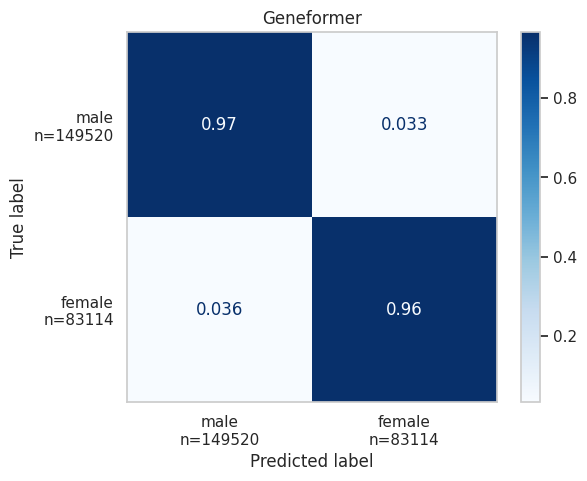

In [52]:
cc.plot_conf_mat(
        conf_mat_dict={"Geneformer": all_metrics_test["conf_matrix"]},
        output_directory=output_dir,
        output_prefix=output_prefix,
        custom_class_order=["male","female"],
)

<Figure size 1500x1500 with 0 Axes>

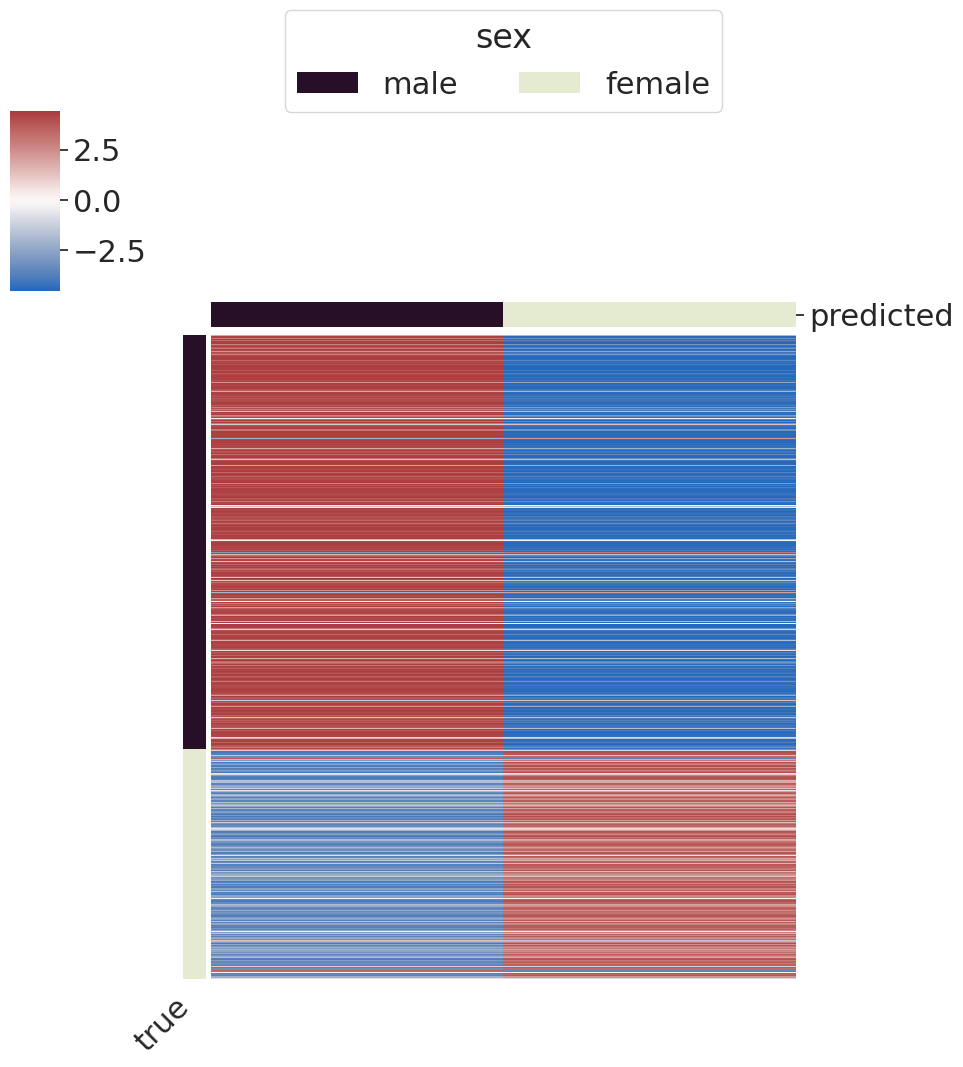

In [54]:
cc.plot_predictions(
    predictions_file=f"{output_dir}/{output_prefix}_pred_dict.pkl",
    id_class_dict_file="/hpcfs/users/a1841503/Geneformer/cellnexus/data/sex/cell_type/prepared_tokenized_combined_data/sex_classifier_cellnexus_v2_blood_cell_type_as_covariate_id_class_dict.pkl",
    title="sex",
    output_directory=output_dir,
    output_prefix=output_prefix,
    custom_class_order=["male","female"],
)


In [55]:
all_metrics_test

{'conf_matrix':           male  female
 male    144556    4964
 female    3032   80082,
 'macro_f1': 0.9627686375569465,
 'acc': 0.9656284120120017,
 'all_roc_metrics': {'mean_tpr': array([0.        , 0.84995308, 0.92647448, 0.9590442 , 0.97342205,
         0.98148326, 0.98611546, 0.9896648 , 0.99207113, 0.99383979,
         0.99525952, 0.99611377, 0.99696802, 0.99748538, 0.9978343 ,
         0.99819525, 0.99843588, 0.99854417, 0.9987848 , 0.99895324,
         0.99906153, 0.99918185, 0.99931419, 0.99938638, 0.99945857,
         0.99951873, 0.99961499, 0.99967514, 0.99972327, 0.99974733,
         0.9997714 , 0.99979546, 0.99983156, 0.99984359, 0.99986765,
         0.99986765, 0.99989171, 0.99989171, 0.99990375, 0.99991578,
         0.99992781, 0.99992781, 0.99992781, 0.99993984, 0.99995187,
         0.99995187, 0.99995187, 0.99995187, 0.9999639 , 0.9999639 ,
         0.99997594, 0.99997594, 1.        , 1.        , 1.        ,
         1.        , 1.        , 1.        , 1.        , 1.  